# Looking at the randomness (or otherwise) of mouse behaviour
### Also, the randomness (or otherwise) of trial types to know when best to start looking at 'full task' behaviour

In [1]:
# Import libraries
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns 
import random
import copy
import numpy as np
from scipy.signal import resample
from scipy.stats import zscore
from scipy import interp
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn import cross_validation

In [2]:
# Load data
# data loading function
def data_load_and_parse(mouse_name):
    tt = pd.read_csv('~/work/whiskfree/data/trialtype_' + mouse_name + '.csv',header=None)
    ch = pd.read_csv('~/work/whiskfree/data/choice_' + mouse_name + '.csv',header=None)
    sess = pd.read_csv('~/work/whiskfree/data/session_' + mouse_name + '.csv',header=None)
    AB = pd.read_csv('~/work/whiskfree/data/AB_' + mouse_name + '.csv',header=None)
    
    clean1 = np.nan_to_num(tt) !=0
    clean2 = np.nan_to_num(ch) !=0
    clean = clean1&clean2
    tt_c = tt[clean].values

    ch_c = ch[clean].values
    
    s_c = sess[clean].values
    
    ab_c = AB[clean].values
    
    return tt_c, ch_c, clean, s_c, ab_c

In [3]:
mouse_name = '32_r'
tt, ch, clean, sess, AB = data_load_and_parse(mouse_name)


# work out AB/ON trials
AB_pol = np.nan_to_num(AB) !=0
ON_pol = np.nan_to_num(AB) ==0
cm_AB = confusion_matrix(tt[AB_pol],ch[AB_pol])
cm_ON = confusion_matrix(tt[ON_pol],ch[ON_pol])
print(cm_AB)
print(cm_ON)
print(accuracy_score(tt[AB_pol],ch[AB_pol]))
print(accuracy_score(tt[ON_pol],ch[ON_pol]))

[[401  32  42]
 [ 18 291  43]
 [ 91  63 280]]
[[199  14  27]
 [ 10 196  15]
 [ 27  54 247]]
0.770816812054
0.813688212928


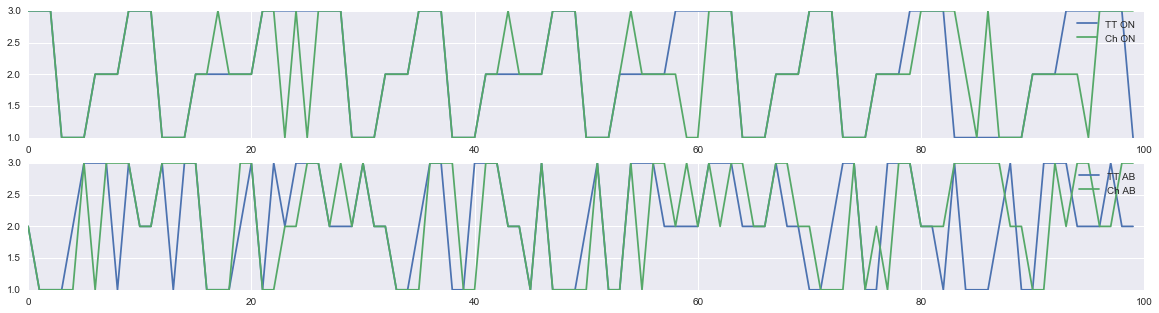

In [4]:
# Format TT/ choice data and plot
fig, ax = plt.subplots(2,1,figsize=(20,5))
_ = ax[0].plot(tt[ON_pol][:100],label='TT ON')
_ = ax[0].plot(ch[ON_pol][:100],label='Ch ON')
ax[0].legend()
_ = ax[1].plot(tt[AB_pol][:100],label='TT AB')
_ = ax[1].plot(ch[AB_pol][:100],label='Ch AB')
ax[1].legend()

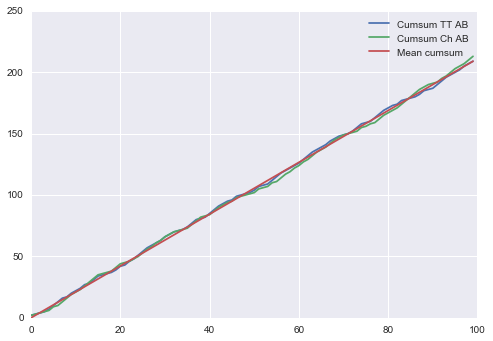

In [26]:
# Measure randomness and plot that
# First plot cumsum of trial types. Periods of bias (of choice 1 and 3, anyway) will be seen as deviations from the mean line
plt.plot(np.cumsum(tt[AB_pol][:100]),label='Cumsum TT AB')
plt.plot(np.cumsum(ch[AB_pol][:100]),label='Cumsum Ch AB')
plt.plot([0,99],[0,np.sum(tt[AB_pol][:100])],label='Mean cumsum')
plt.legend()

/Users/mathew/miniconda/envs/graph_tool/lib/python3.4/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 2050 but corresponding boolean dimension is 1261
/Users/mathew/miniconda/envs/graph_tool/lib/python3.4/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 2050 but corresponding boolean dimension is 1261
/Users/mathew/miniconda/envs/graph_tool/lib/python3.4/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 2050 but corresponding boolean dimension is 1261


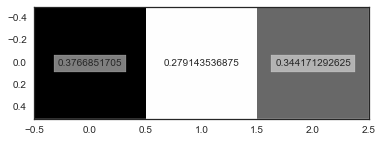

In [4]:
# How about looking at the distribution of individual states, pairs, triples. 
# Compare to random sequence (with no conditions)
P_i = np.zeros(3)
P_i[0] = len(tt[tt[AB_pol]==1])
P_i[1] = len(tt[tt[AB_pol]==2])
P_i[2] = len(tt[tt[AB_pol]==3])
with sns.axes_style("white"):
    _ = plt.imshow(np.expand_dims(P_i/sum(P_i),axis=0),interpolation='none')
    for j in range(0,3):
        plt.text(j, 0, P_i[j]/sum(P_i), va='center', ha='center',bbox=dict(facecolor='white',edgecolor='white', alpha=0.5))

#     _ = ax[1].bar([0,1,2],P_i/sum(P_i))



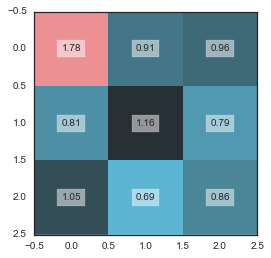

In [32]:
# Pairs and triples (in dumb O(n) format)
P_ij = np.zeros([3,3])
P_ijk = np.zeros([3,3,3])
for i in range(len(tt[AB_pol]) - 2):
    #p_i = tt[AB_pol][i]
    #p_j = tt[AB_pol][i+1]
    #p_k = tt[AB_pol][i+2]
    p_i = ch[AB_pol][i]
    p_j = ch[AB_pol][i+1]
    p_k = ch[AB_pol][i+2]
    P_ij[p_i-1,p_j-1] += 1
    P_ijk[p_i-1,p_j-1,[p_k-1]] += 1
    
cmap = sns.diverging_palette(220,10, l=70, as_cmap=True, center="dark") # blue to green via black

with sns.axes_style("white"):
    plt.imshow(P_ij/np.sum(P_ij),interpolation='none',cmap=cmap)
    
for i in range(0,3):
    for j in range(0,3):
        plt.text(j, i, "{0:.2f}".format(P_ij[i,j]/np.sum(P_ij)*9), va='center', ha='center',bbox=dict(facecolor='white',edgecolor='white', alpha=0.5))

#plt.savefig('figs/graphs/state_transition_matrix_'+ mouse_name +'.svg')
plt.savefig('figs/graphs/choice_state_transition_matrix_AB'+ mouse_name +'.png')

0.037037037037037035

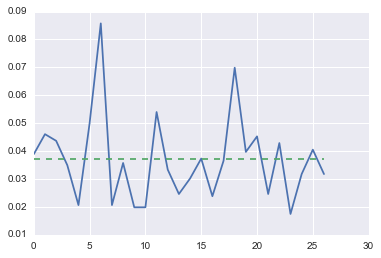

In [63]:
# Plot P(state) for all 27 triple states
plt.plot(P_ijk.flatten()/np.sum(P_ijk))
plt.plot([0,26],[1/27,1/27],'--')
1/27

In [6]:
import graph_tool.all as gt


/Users/mathew/miniconda/envs/graph_tool/lib/python3.4/site-packages/graph_tool/draw/cairo_draw.py:1468: RuntimeWarning: Error importing Gtk module: No module named 'gi'; GTK+ drawing will not work.
  warnings.warn(msg, RuntimeWarning)


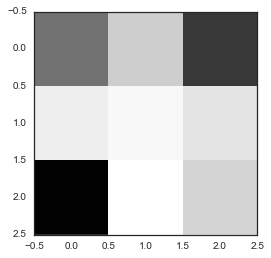

In [9]:
# Transition probabilities between individual states, pairs, triples
g = gt.Graph()
g.add_edge_list(np.transpose(P_ij.nonzero()))
with sns.axes_style("white"):
	plt.imshow(P_ij,interpolation='none')

In [20]:
g = gt.Graph(directed = True)
g.add_vertex(len(P_ij))
edge_weights = g.new_edge_property('double')
edge_labels = g.new_edge_property('string')
for i in range(P_ij.shape[0]):
  for j in range(P_ij.shape[1]):
    e = g.add_edge(i, j)
    edge_weights[e] = P_ij[i,j]
    edge_labels[e] = str(P_ij[i,j])
    

[60 60 60]


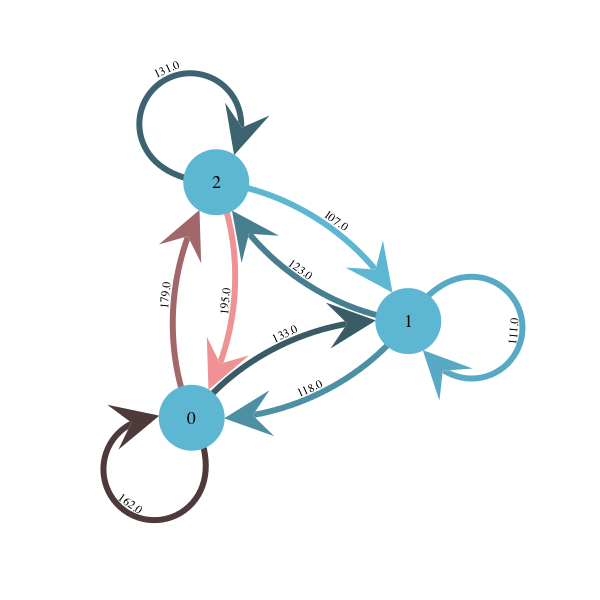

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x113cfc588, at 0x128af08d0>

In [21]:
# Fancy drawing code where node colour/size is degree. Edge colour/size is betweenness
deg = g.degree_property_map("in")
# deg.a = 4 * (np.sqrt(deg.a) * 0.5 + 0.4)
deg.a = deg.a*20
print(deg.a)
ewidth = edge_weights.a / 10
#ebet.a /= ebet.a.max() / 10.
#print(ebet.a)
pos = gt.sfdp_layout(g)
#control = g.new_edge_property("vector<double>")
#for e in g.edges():
#  d = np.sqrt(sum((pos[e.source()].a - pos[e.target()].a) ** 2))
#  print(d)
#  control[e] = [10, d, 10,d] #[0.3, d, 0.7, d]
  
  

cmap = sns.cubehelix_palette(as_cmap=True)  # cubehelix 
cmap = sns.diverging_palette(220,10, l=70, as_cmap=True, center="dark") # blue to green via black
# gt.graph_draw(g, pos=pos, vertex_size=deg, vertex_fill_color=deg, vorder=deg,
#              edge_color=ebet, eorder=eorder, edge_pen_width=ebet,
#              edge_control_points=control) # some curvy edges
              # output="graph-draw.pdf")
gt.graph_draw(g, pos=pos, vertex_size=deg, vertex_color=deg, vertex_fill_color=deg,  edge_color=edge_weights, edge_text=edge_labels,
              vcmap=cmap,ecmap=cmap, vertex_text=g.vertex_index, vertex_font_size=18,fit_view=0.5)
              #vcmap=plt.cm.Pastel1,ecmap=plt.cm.Pastel1 )
       #       edge_control_points=control) # some curvy edges
              # output="graph-draw.pdf")

In [33]:
# Same as g but normalised so total trials/9 = 1
g_n = gt.Graph(directed = True)

edge_weights_n = g_n.new_edge_property('double')
edge_labels_n = g_n.new_edge_property('string')
node_size_n = g_n.new_vertex_property('double')
g_n.add_vertex(len(P_ij))

P_ij_n = P_ij /(P_ij.sum()/9)
for i in range(P_ij.shape[0]):
  #v = g_n.add_vertex()
  node_size_n[i] = 3* sum(P_ij)[i] / np.sum(P_ij)
  for j in range(P_ij.shape[1]):
    e = g_n.add_edge(i, j)
    edge_weights_n[e] = P_ij_n[i,j]
    edge_labels_n[e] = "{0:.2f}".format(P_ij_n[i,j])

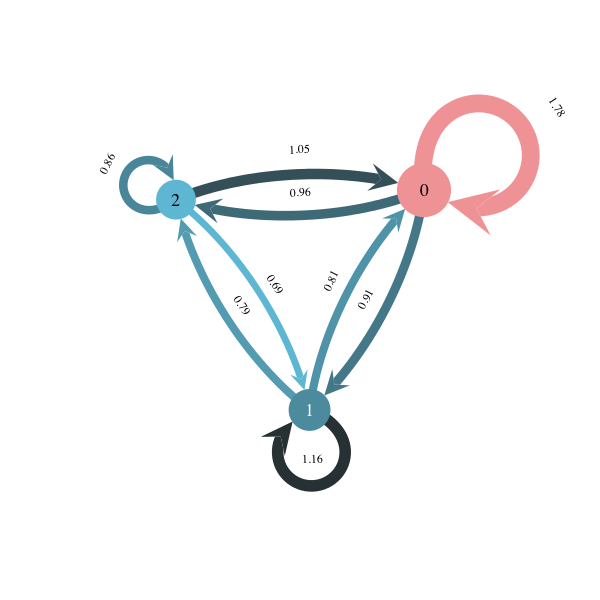

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x11425a940, at 0x12a68b6a0>

In [34]:
# Minimal drawing code, but with scaled colours/weights for network properties
# Line width changes on each loop ATM. Needs fixing..
pos = gt.sfdp_layout(g_n)  

#deg_n = g_n.degree_property_map("in")
# deg.a = 4 * (np.sqrt(deg.a) * 0.5 + 0.4)
#deg_n.a = deg_n.a*20
n_size = copy.copy(node_size_n)
n_size.a = 50* n_size.a/ max(n_size.a)

edge_w = copy.copy(edge_weights_n)
edge_w.a = edge_w.a*10

cmap = sns.cubehelix_palette(as_cmap=True)  # cubehelix 
cmap = sns.diverging_palette(220,10, l=70, as_cmap=True, center="dark") # blue to green via black

gt.graph_draw(g_n, pos=pos, vertex_color = n_size, vertex_fill_color = n_size, 
              vertex_size = n_size,
              edge_pen_width=edge_w, edge_color=edge_weights_n, 
              edge_text=edge_labels_n,
              vcmap=cmap,ecmap=cmap, 
              vertex_text=g_n.vertex_index, 
              vertex_font_size=18,fit_view=0.5,output="choice_1st_order_transition_AB.pdf")
              #vcmap=plt.cm.Pastel1,ecmap=plt.cm.Pastel1 )
       #       edge_control_points=control) # some curvy edges
              # output="graph-draw.pdf")

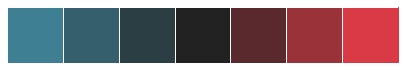

In [41]:
current_palette = sns.color_palette("cubehelix")
current_palette = sns.diverging_palette(220,10, l=50, n=7, center="dark")
sns.palplot(current_palette)



In [35]:
#  Now write a loop to construct a tree-type graph
# Same as g but normalised so total trials/9 = 1
t = gt.Graph(directed = False)

P_ij_n = P_ij /(P_ij.sum()/9)
P_ijk_n = P_ijk /(P_ijk.sum()/27)

edge_weights_t = t.new_edge_property('double')
edge_labels_t = t.new_edge_property('string')
node_labels_t = t.new_vertex_property('string')
node_size = t.new_vertex_property('double')
h = t.add_vertex()
node_labels_t[h] = "0"

for i in range(P_ij.shape[0]):
  v = t.add_vertex()
  node_labels_t[v] = str(i)
  e = t.add_edge(h,v)
  node_size[v] = sum(P_ij_n)[i] *10
  
  for j in range(P_ij.shape[1]):
    v2 = t.add_vertex()
    node_labels_t[v2] = str(i) + "-" + str(j)
    e = t.add_edge(v,v2)
    
    edge_weights_t[e] = P_ij_n[i,j]*10
    edge_labels_t[e] = "{0:.2f}".format(P_ij_n[i,j])
    node_size[v2] = P_ij_n[i,j]*20
    
    for k in range(P_ijk.shape[2]):
      v3 = t.add_vertex()
      node_labels_t[v3] = str(i) + "-" + str(j) + "-" + str(k)
      e2 = t.add_edge(v2,v3)
      
      edge_weights_t[e2] = P_ijk_n[i,j,k]*10
      edge_labels_t[e2] = "{0:.2f}".format(P_ijk_n[i,j,k])
      node_size[v3] = P_ijk_n[i,j,k]*20


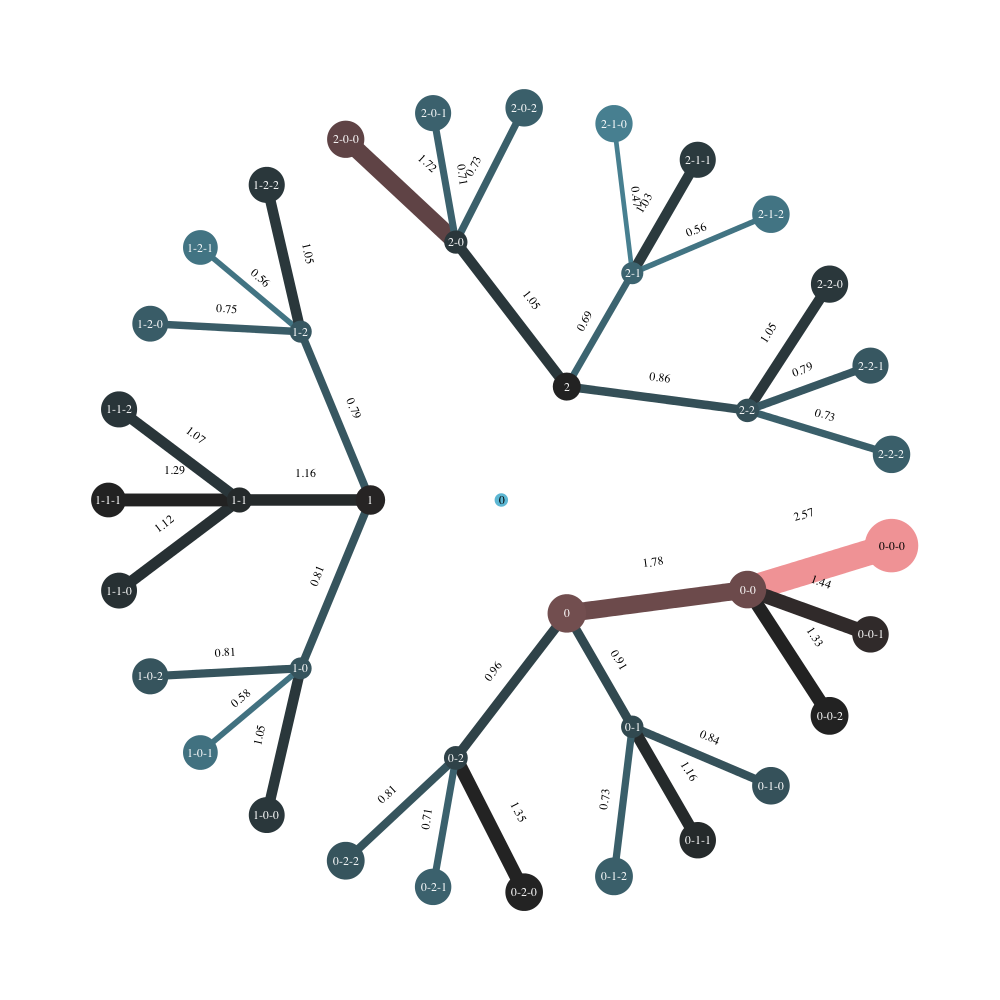

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x12ad5cba8, at 0x127823278>

In [36]:
#pos = gt.sfdp_layout(t) 
#pos = gt.fruchterman_reingold_layout(t)
pos = gt.radial_tree_layout(t,t.vertex(0))
cmap = sns.diverging_palette(220,10, l=70, as_cmap=True, center="dark") # blue to green via black

gt.graph_draw(t,pos=pos,vertex_size=node_size,edge_pen_width=edge_weights_t,
              vertex_text = node_labels_t, edge_text=edge_labels_t,
              ecmap=cmap, edge_color = edge_weights_t,
              vcmap=cmap, vertex_color = node_size,vertex_fill_color = node_size,
              output_size=(1000, 1000), fit_view=0.8,
              output="figs/graphs/choice_3_step_statespace_AB.pdf")

In [10]:
"{0:.2f}".format(P_ijk[1,1,1])

'31.00'

In [10]:
"{0:.2f}".format(P_ijk[1,1,1])

'31.00'

In [23]:
len(P_ij)

array([ 3.39555203,  2.50913423,  3.09531374])

# Repeat the trick for ON policy trials

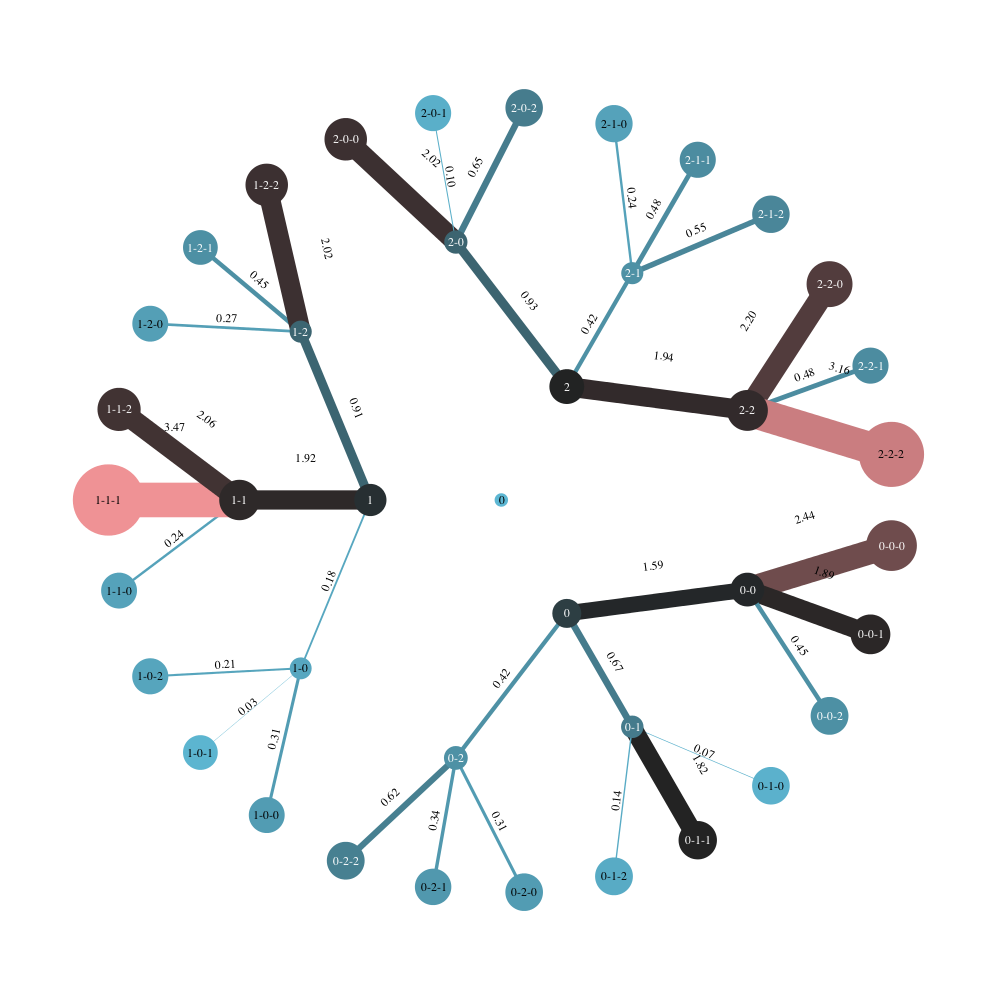

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x12aba8128, at 0x12aba8390>

In [37]:
# P_ijk_ON
P_ij_ON = np.zeros([3,3])
P_ijk_ON = np.zeros([3,3,3])
for i in range(len(tt[ON_pol]) - 2):
    #p_i = tt[ON_pol][i]
    #p_j = tt[ON_pol][i+1]
    #p_k = tt[ON_pol][i+2]
    p_i = ch[ON_pol][i]
    p_j = ch[ON_pol][i+1]
    p_k = ch[ON_pol][i+2]
    P_ij_ON[p_i-1,p_j-1] += 1
    P_ijk_ON[p_i-1,p_j-1,[p_k-1]] += 1

# Make graph
t_ON = gt.Graph(directed = False)

P_ij_ON = P_ij_ON /(P_ij_ON.sum()/9)
P_ijk_ON = P_ijk_ON /(P_ijk_ON.sum()/27)

edge_weights_tON = t_ON.new_edge_property('double')
edge_labels_tON = t_ON.new_edge_property('string')
node_labels_tON = t_ON.new_vertex_property('string')
node_size_ON = t_ON.new_vertex_property('double')
h = t_ON.add_vertex()
node_labels_tON[h] = "0"

for i in range(P_ij_ON.shape[0]):
  v = t_ON.add_vertex()
  node_labels_tON[v] = str(i)
  e = t_ON.add_edge(h,v)
  node_size_ON[v] = sum(P_ij_ON)[i] *10
  
  for j in range(P_ij_ON.shape[1]):
    v2 = t_ON.add_vertex()
    node_labels_tON[v2] = str(i) + "-" + str(j)
    e = t_ON.add_edge(v,v2)
    
    edge_weights_tON[e] = P_ij_ON[i,j]*10
    edge_labels_tON[e] = "{0:.2f}".format(P_ij_ON[i,j])
    node_size_ON[v2] = P_ij_ON[i,j]*20
    
    for k in range(P_ijk_ON.shape[2]):
      v3 = t_ON.add_vertex()
      node_labels_tON[v3] = str(i) + "-" + str(j) + "-" + str(k)
      e2 = t_ON.add_edge(v2,v3)
      
      edge_weights_tON[e2] = P_ijk_ON[i,j,k]*10
      edge_labels_tON[e2] = "{0:.2f}".format(P_ijk_ON[i,j,k])
      node_size_ON[v3] = P_ijk_ON[i,j,k]*20

# Plot graph
pos = gt.radial_tree_layout(t_ON,t_ON.vertex(0))
cmap = sns.diverging_palette(220,10, l=70, as_cmap=True, center="dark") # blue to green via black

gt.graph_draw(t_ON,pos=pos,vertex_size=node_size_ON,edge_pen_width=edge_weights_tON,
              vertex_text = node_labels_tON, edge_text=edge_labels_tON,
              ecmap=cmap, edge_color = edge_weights_tON,
              vcmap=cmap, vertex_color = node_size_ON,
              vertex_fill_color = node_size_ON,
              output_size=(1000, 1000), fit_view=0.8,
              output="figs/graphs/choice_3_step_statespace_ON_"+ mouse_name +".pdf")


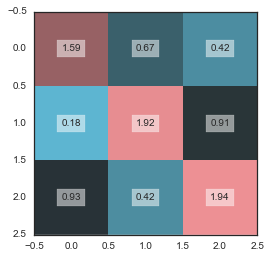

In [38]:
# image of ON trials transition matrix
cmap = sns.diverging_palette(220,10, l=70, as_cmap=True, center="dark") # blue to green via black

with sns.axes_style("white"):
    plt.imshow(P_ij_ON/np.sum(P_ij_ON),interpolation='none',cmap=cmap)
    
for i in range(0,3):
    for j in range(0,3):
        plt.text(j, i, "{0:.2f}".format(P_ij_ON[i,j]), va='center', ha='center',bbox=dict(facecolor='white',edgecolor='white', alpha=0.5))

plt.savefig('figs/graphs/choice_state_transition_matrix_ON_'+ mouse_name +'.png')

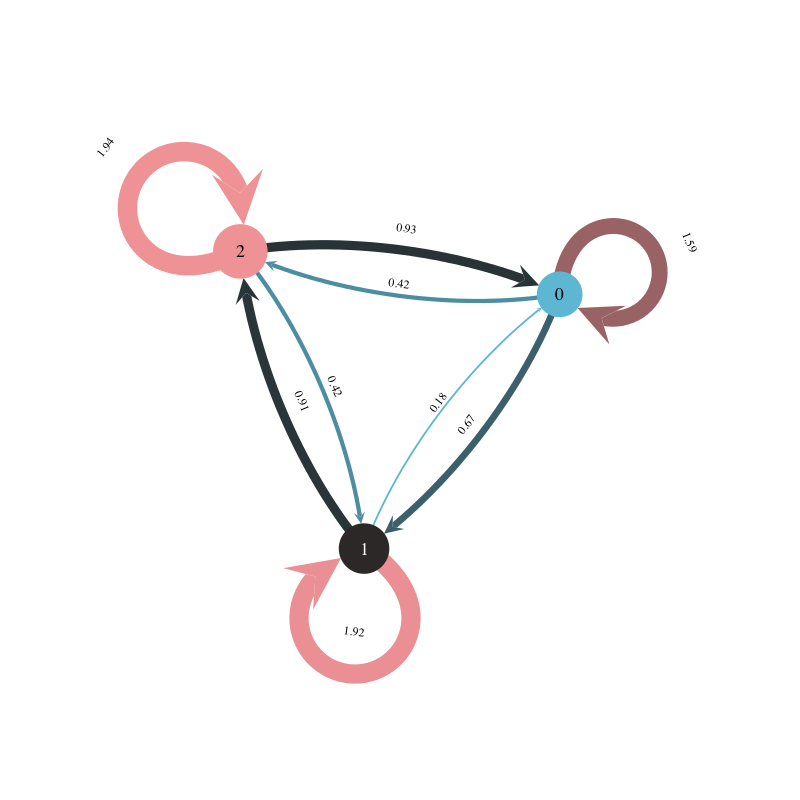

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x12ac38898, at 0x12ac383c8>

In [40]:
# First order transition graph
g_ON = gt.Graph(directed = True)

edge_weights_ON = g_ON.new_edge_property('double')
edge_labels_ON = g_ON.new_edge_property('string')
node_size_ON = g_ON.new_vertex_property('double')
g_ON.add_vertex(len(P_ij_ON))

for i in range(P_ij_ON.shape[0]):
  #v = g_n.add_vertex()
  node_size_ON[i] = 3* sum(P_ij_ON)[i] / np.sum(P_ij_ON)
  for j in range(P_ij_ON.shape[1]):
    e = g_ON.add_edge(i, j)
    edge_weights_ON[e] = P_ij_ON[i,j]
    edge_labels_ON[e] = "{0:.2f}".format(P_ij_ON[i,j])
    
# Plot graph
pos = gt.sfdp_layout(g_ON)  
n_size = copy.copy(node_size_ON)
n_size.a = 50* n_size.a/ max(n_size.a)

edge_w = copy.copy(edge_weights_ON)
edge_w.a = edge_w.a*10

cmap = sns.cubehelix_palette(as_cmap=True)  # cubehelix 
cmap = sns.diverging_palette(220,10, l=70, as_cmap=True, center="dark") # blue to green via black

gt.graph_draw(g_ON, pos=pos, vertex_color = n_size, vertex_fill_color = n_size, 
              vertex_size = n_size,
              edge_pen_width=edge_w, edge_color=edge_w, 
              edge_text=edge_labels_ON,
              vcmap=cmap,ecmap=cmap, 
              vertex_text=g_ON.vertex_index, 
              vertex_font_size=18,
              output_size=(800, 800), fit_view=0.45,
              output="figs/graphs/choice_1st_order_transition_ON"+ mouse_name +".pdf")


# Finally, transition probabilities for choices - do they follow the trial types?
## (Actually, let's just re-run the code from above changing tt to ch)

# Now, let's use graphs to visualise confusion matrices

In [42]:
cm_AB = confusion_matrix(tt[AB_pol],ch[AB_pol])
cm_ON = confusion_matrix(tt[ON_pol],ch[ON_pol])
print(cm_AB)
print(cm_ON)
print(accuracy_score(tt[AB_pol],ch[AB_pol]))
print(accuracy_score(tt[ON_pol],ch[ON_pol]))

[[401  32  42]
 [ 18 291  43]
 [ 91  63 280]]
[[199  14  27]
 [ 10 196  15]
 [ 27  54 247]]
0.770816812054
0.813688212928


In [47]:
with sns.axes_style("white"):
  fig, ax = plt.subplots(2,1)
    ax[0].imshow(cm_AB/np.sum(cm_AB),interpolation='none',cmap=cmap)
    
for i in range(0,3):
    for j in range(0,3):
        ax[0].text(j, i, "{0:.2f}".format(cm_AB[i,j]), va='center', ha='center',bbox=dict(facecolor='white',edgecolor='white', alpha=0.5))

plt.savefig('figs/graphs/confusion_matrix_AB_'+ mouse_name +'.png')

IndentationError: unexpected indent (<ipython-input-47-dccc62f93d95>, line 3)

# Should also look at patterns in licking wrt correct/incorrect 

In [21]:
for v in g.vertices():
    print(v)
for e in g.edges():
    print(e)

0
1
2
(0, 0)
(0, 1)
(0, 2)
(1, 0)
(1, 1)
(1, 2)
(2, 0)
(2, 1)
(2, 2)


In [48]:
19.19 - 9.92


9.270000000000001

In [20]:
# gt.graph_draw(g,output_size=(400,400),fit_view=True,output='simple_graph.pdf')
gt.graph_draw(g2,output_size=(400,400),fit_view=True)

NameError: name 'g2' is not defined

In [12]:
deg.

SyntaxError: invalid syntax (<ipython-input-12-8cc4de3b5afe>, line 1)

In [5]:
# Stats...

In [81]:
len(tt[tt[AB_pol]])

1261

In [13]:
gt.graph_draw?